In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import numpy as np
import pytz
import re


In [2]:
# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

In [3]:
data['date'] = pd.to_datetime(data['date'])

def convert_utc_to_cet(df, date_column='date'):
    """
    Convert UTC timestamps to Central European Time (CET/CEST) with proper DST handling
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the date column
    date_column (str): Name of the column containing UTC timestamps
    
    Returns:
    pd.DataFrame: DataFrame with converted timestamps
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure timestamps are UTC aware
    if df[date_column].dt.tz is None:
        df[date_column] = df[date_column].dt.tz_localize('UTC')
    elif df[date_column].dt.tz != pytz.UTC:
        df[date_column] = df[date_column].dt.tz_convert('UTC')
    
    # Convert to CET/CEST (Europe/Berlin includes proper DST handling)
    df[date_column] = df[date_column].dt.tz_convert('Europe/Berlin')
    
    return df

data = convert_utc_to_cet(data)

In [4]:
data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("CHILI_POE", "chili_con_bacon")
data["user"] = data["user"].replace("chili_conbacon", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("trek_x", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")
data["user"] = data["user"].replace("uuccugr", "uuccugr_")                                  
data["user"] = data["user"].replace("StanIV4_", "stan_iv4")

In [5]:
# Get all unique usernames
unique_users = data['user'].unique()

# Create a mapping from lowercase username to all variants

user_variants = defaultdict(set)
for user in unique_users:
    user_variants[user.lower()].add(user)

# Find usernames with different capitalization
duplicate_users = {k: v for k, v in user_variants.items() if len(v) > 1}

In [6]:
# Create a mapping from all variants to the canonical (sorted first) variant
variant_map = {}
for variants in duplicate_users.values():
    sorted_variants = sorted(variants)
    canonical = sorted_variants[0]
    for v in variants:
        variant_map[v] = canonical

# Replace usernames in 'user' column
data['user'] = data['user'].apply(lambda u: variant_map.get(u, u))

In [7]:
mod_start = {
    "Substen": "2022-07-11 19:00:00",
    "StreamElements": "2023-07-17 00:00:00",
    "banties_x": "2023-07-17 00:00:00",
    "Aloddin": "2023-08-13 00:00:00",
    "Martin_Gales": "2023-10-24 00:00:00",
    "Nigthbot": "2024-02-27 00:00:00",
    "klimzaa": "2024-04-08 00:00:00",
    "IvanOnMyOwn": "2024-04-08 00:00:00",
    "Ivana_10": "2024-04-08 00:00:00",
    "balintboss": "2024-04-08 00:00:00",
    "Ravenbtw": "2024-04-08 00:00:00",
    "gkey": "2024-06-22 23:01:00",
    "07moki": "2024-06-22 23:01:00",
    "Fossabot": "2024-07-25 20:52:00",
    "Hueqi": "2024-06-22 23:02:00",
    "Aluminiumminimumimmunity": "2024-04-08 19:41:00",
    "Roonss": "2024-08-26 00:00:00",
    "1206paul_": "2023-12-10 00:00:00",
    "55Dash": "2025-01-14 16:31:00",
    "dima_wallhacks": "2025-03-05 14:40:00",
    "lovcen": "2025-05-25 19:19:00",
    "Trizze": "2025-05-26 14:46:00",
    "shogalul": "2025-08-11 17:01:00"
}

In [8]:
data["after_mod"] = False
for user, start_time in mod_start.items():
    data.loc[
        (data["user"] == user) & (data["date"] > start_time),
        "after_mod"
    ] = True

In [9]:
stream_stats = data.groupby("stream").agg(
    total_messages=("message", "count"),
    start_date=("date", "min"),
    mod_messages=("after_mod", "sum")
)

In [10]:
stream_stats["mod_percentage"] = (
    stream_stats["mod_messages"] / stream_stats["total_messages"] * 100
)

In [11]:
# Find the stream with the highest %
max_stream = stream_stats["mod_percentage"].idxmax()
max_value = stream_stats["mod_percentage"].max()

In [12]:
print(f"Stream {max_stream} {stream_stats.loc[max_stream, 'start_date'].date()} had the highest % of mod messages: {max_value:.2f}%")


Stream 30 2024-06-02 had the highest % of mod messages: 54.22%


In [13]:
# Find the stream with the lowest %
min_stream = stream_stats["mod_percentage"].idxmin()
min_value = stream_stats["mod_percentage"].min()

In [14]:
print(f"Stream {min_stream} {stream_stats.loc[min_stream, 'start_date'].date()} had the lowest % of mod messages: {min_value:.2f}%")


Stream 389 2025-08-10 had the lowest % of mod messages: 5.20%


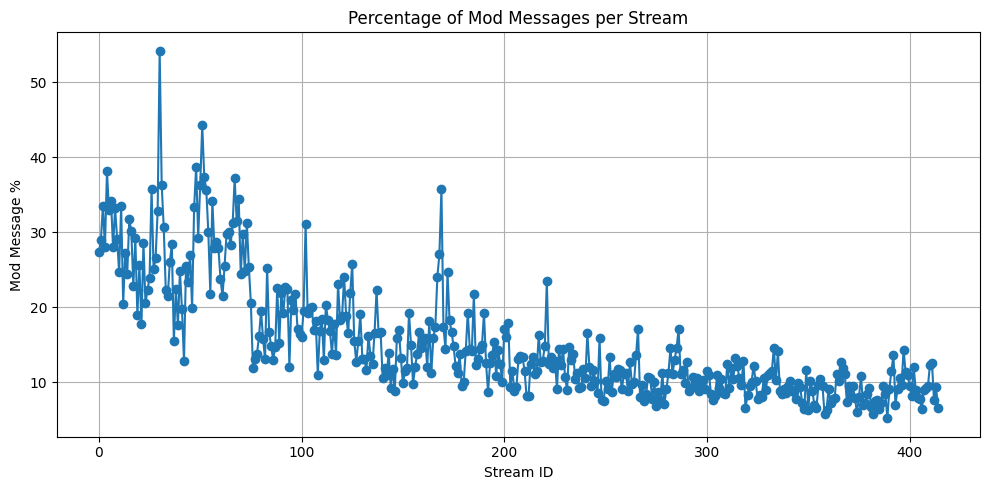

In [15]:
import matplotlib.pyplot as plt

# Sort by stream (optional, so x-axis is chronological)
stream_stats_sorted = stream_stats.sort_index()

plt.figure(figsize=(10, 5))
plt.plot(
    stream_stats_sorted.index, 
    stream_stats_sorted["mod_percentage"], 
    marker="o", 
    linestyle="-"
)

plt.title("Percentage of Mod Messages per Stream")
plt.xlabel("Stream ID")
plt.ylabel("Mod Message %")
plt.grid(True)
plt.tight_layout()
plt.show()


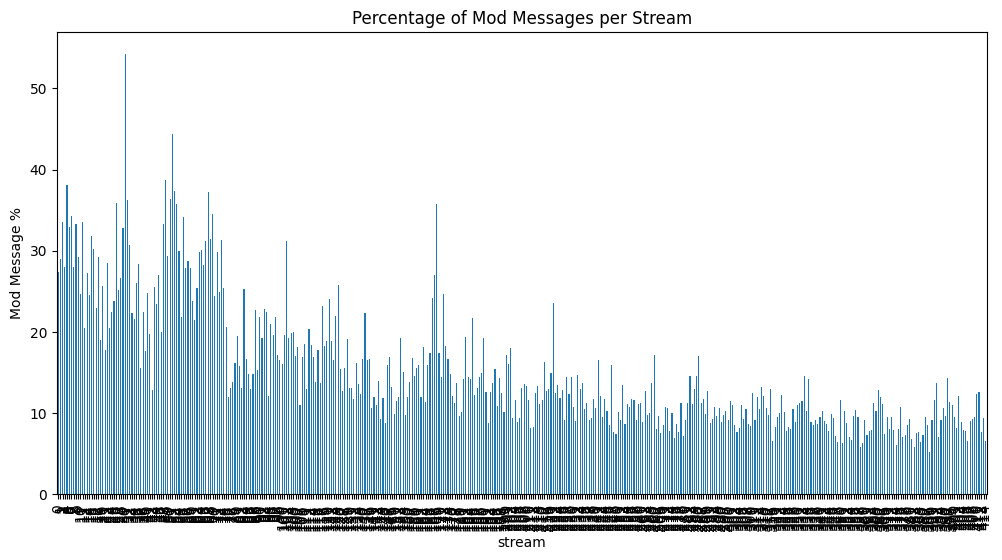

In [16]:
stream_stats_sorted["mod_percentage"].plot(
    kind="bar", figsize=(12, 6), ylabel="Mod Message %", title="Percentage of Mod Messages per Stream"
)
plt.show()


In [17]:
# group by stream and then by 10min windows
mod_windows = (
    data.groupby("stream")
    .resample("10T", on="date")
    .agg(
        total_messages=("message", "count"),
        mod_messages=("after_mod", "sum")
    )
    .reset_index()
)

# calculate %
mod_windows["mod_percentage"] = (
    mod_windows["mod_messages"] / mod_windows["total_messages"] * 100
)

peak = mod_windows.loc[mod_windows["mod_percentage"].idxmax()]

print(
    f"Biggest mod % was {peak['mod_percentage']:.2f}% "
    f"in stream {peak['stream']} during window starting {peak['date']}"
)


C:\Users\Kardo\AppData\Local\Temp\ipykernel_23040\2082691097.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("10T", on="date")


Biggest mod % was 100.00% in stream 5 during window starting 2024-05-06 16:50:00+02:00


In [18]:
from datetime import timedelta

longest_streak = None
longest_duration = timedelta(0)

for stream_id, df in data.groupby("stream"):
    in_streak = False
    streak_start = None
    
    for i, row in df.iterrows():
        if row["after_mod"]:
            if not in_streak:
                # start of a new streak
                in_streak = True
                streak_start = row["date"]
        else:
            if in_streak:
                # streak ended
                streak_end = row["date"]
                duration = streak_end - streak_start
                if duration > longest_duration:
                    longest_duration = duration
                    longest_streak = (stream_id, streak_start, streak_end, duration)
                in_streak = False
    
    # check if a streak lasted until the end of the stream
    if in_streak:
        streak_end = df["date"].iloc[-1]
        duration = streak_end - streak_start
        if duration > longest_duration:
            longest_duration = duration
            longest_streak = (stream_id, streak_start, streak_end, duration)


In [19]:
if longest_streak:
    stream_id, start, end, duration = longest_streak
    print(f"Longest only-mod chat was in stream {stream_id}, "
          f"from {start} to {end}, lasting {duration}.")
else:
    print("No mod-only streaks found.")


Longest only-mod chat was in stream 338, from 2025-06-12 16:15:52+02:00 to 2025-06-12 16:32:35+02:00, lasting 0 days 00:16:43.
